![](https://ruder.io/content/images/size/w2000/2016/04/word_embeddings_colah.png)
# What Are Word Embeddings?
A word embedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning.


## Representing text as numbers
Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings
As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. 

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word. However, This approach is inefficient. 

A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.


### Encode each word with a unique number
A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like $[5, 1, 4, 3, 5, 2]$. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:
> The integer-encoding is arbitrary (it does not capture any relationship between words).
> An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings
Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, we do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.


In [2]:
import os
import warnings

# Suppress Tensorflow warnings
# 0 = all, 
# 1 = filter out INFO messages, 
# 2 = filter out INFO and WARNING messages, 
# 3 = filter out all messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

2025-07-21 12:01:13.521239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753079473.542986  966805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753079473.549000  966805 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753079473.567356  966805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753079473.567398  966805 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753079473.567400  966805 computation_placer.cc:177] computation placer alr

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [4]:
embedding_layer = layers.Embedding(input_dim=1000, output_dim=5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [5]:
result = embedding_layer(tf.constant([1,2,3, 999]))
result.numpy()

2025-07-21 12:01:17.469995: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


array([[-0.0468007 , -0.02190587,  0.00131849,  0.03857381, -0.0219506 ],
       [ 0.01014169, -0.04641668, -0.0208461 ,  0.00429722,  0.03119952],
       [ 0.02613201,  0.00502344,  0.03188536, -0.01973411,  0.00753018],
       [ 0.02617231,  0.04503623,  0.00026906, -0.04799347,  0.03047453]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes $(32, 10)$ (batch of 32 sequences of length 10) or $(64, 15)$ (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a $(2, 3)$ input batch and the output is $(2, 3, N)$

In [6]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
print(result.shape)
print(result[0])
print(result[1])

(2, 3, 5)
tf.Tensor(
[[ 0.03009861  0.03926304 -0.0109607   0.01217792 -0.02085043]
 [-0.0468007  -0.02190587  0.00131849  0.03857381 -0.0219506 ]
 [ 0.01014169 -0.04641668 -0.0208461   0.00429722  0.03119952]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 0.02613201  0.00502344  0.03188536 -0.01973411  0.00753018]
 [ 0.03151495  0.02536908  0.0225888   0.03560567  0.02735073]
 [ 0.00806137 -0.00850574  0.0177815   0.01414937  0.03241012]], shape=(3, 5), dtype=float32)


When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape **(samples, sequence_length, embedding_dimensionality).** To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an **RNN, Attention, or pooling layer** before passing it to a Dense layer. This tutorial uses pooling because it's simplest.

## Learning embeddings from scratch

[Large Movie Review Dataset.](https://ai.stanford.edu/~amaas/data/sentiment/) This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It contains a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional 50000 unlabeled data for use as well.

One of the common tricks is to use the total 100,000 samples to train a language model which essentially predicts the next word of a sequence given a series of words before that and later on using that model for classification. However, in this notebook, I am simply using them for demonstrating word embeddings. So, I will just work on a small subset of the whole dataset containing vocabulary size of 8,000 words. You are free to explore the other larger version of the dataset from the tensorflow dataframes on [imdb reviews](https://www.tensorflow.org/datasets/catalog/imdb_reviews) ready to use.




In [7]:
# Load IMDB dataset with subword tokenization
(train_data, test_data), info = tfds.load('imdb_reviews/plain_text',
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          data_dir="/work/data/TrainingSession/202/imdb_reviews",
                                          with_info=True,
                                          as_supervised=True)

In [8]:
# Print first 5 examples from the training set
for example, label in train_data.take(5):
    print(f"Review: {example.numpy()}\nLabel: {label.numpy()}\n")

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0

Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish

Using <code>'imdb_reviews/plain_text'</code> configuration, the dataste doesn't have a subword encoder. The <code>plain_text</code> configuration provides raw text without tokenization.

## **NOTE:**

Get the encoder [(tfds.features.text.SubwordTextEncoder)](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder), and have a quick look at the vocabulary.
The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [9]:
encoder = info.features['text'].encoder
type(encoder)

NoneType

In [10]:
# Create custom tokenizer
def custom_tokenizer(dataset, vocab_size=1000):
    """ Create vocabulary and tokenizer for the dataset """
    all_text = []
    for text, label in dataset.take(1000): 
        all_text.append(text.numpy().decode('utf-8'))
        
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=vocab_size,
        oov_token="<OOV>"
    )
    tokenizer.fit_on_texts(all_text)
    return tokenizer

In [11]:
# Create a subword tokenizer and vocab size
tokenizer = custom_tokenizer(train_data)
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"Vocabulary size: {vocab_size}")
print(f"Sample words: {list(tokenizer.word_index.keys())[:10]}")

Vocabulary size: 18720
Sample words: ['<OOV>', 'the', 'a', 'and', 'of', 'to', 'is', 'br', 'in', 'i']


In [12]:
# Convert text to sequences first
def text_to_sequences(dataset, tokenizer, max_len=500):
    texts = []
    labels = []
    
    for text, label in dataset:
        # Convert bytes to string and tokenize
        text_str = text.numpy().decode('utf-8')
        sequence = tokenizer.texts_to_sequences([text_str])[0]
        # Pad or truncate
        if len(sequence) > max_len:
            sequence = sequence[:max_len]
        else:
            sequence = sequence + [0] * (max_len - len(sequence))
        
        texts.append(sequence)
        labels.append(label.numpy())
    
    return tf.data.Dataset.from_tensor_slices((texts, labels))

# Process datasets
train_sequences = text_to_sequences(train_data.take(1000), tokenizer)  # Take subset for demo
test_sequences = text_to_sequences(test_data.take(500), tokenizer)

# Create batches
train_batches = train_sequences.batch(32)
test_batches = test_sequences.batch(32)

### Create a simple model

I will use the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to define our model. In this case it is a ["Continuous bag of words (CBOW)"](https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314) style model. **In the CBOW model, the distributed representations of context (or surrounding words) are combined to predict the word in the middle. The exact opposite model is the Skip-Gram model,  that is based on a single target word, the sorrounding words (contexts) are predicted** The following figure will clarify them for sure. ![](https://miro.medium.com/max/875/1*cuOmGT7NevP9oJFJfVpRKA.png)

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input, so the padding length may affect the output.  To fix this, see the [masking and padding guide](../../guide/keras/masking_and_padding).

In [13]:
embedding_dim = 32

model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
#   layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

### Compile and train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(train_batches,
                    epochs=5,
                    validation_data=test_batches,
                    validation_steps=250)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4910 - loss: 0.6938 - val_accuracy: 0.5020 - val_loss: 0.6920
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4910 - loss: 0.6930 - val_accuracy: 0.5020 - val_loss: 0.6905
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4910 - loss: 0.6915 - val_accuracy: 0.5020 - val_loss: 0.6886
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4910 - loss: 0.6895 - val_accuracy: 0.5020 - val_loss: 0.6870
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4910 - loss: 0.6876 - val_accuracy: 0.5020 - val_loss: 0.6854


In [25]:
def visualize_training(history, lw = 3):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(fontsize = 'x-large')


    plt.subplot(2,1,2)
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.grid(True)
    plt.show()

#     plt.figure(figsize=(10,5))
#     plt.plot(history.history['lr'], label = 'lr', marker = '*',linewidth = lw)
#     plt.title('Learning Rate')
#     plt.xlabel('Epochs')
#     plt.ylabel('Learning Rate')
#     plt.grid(True)
#     plt.show()

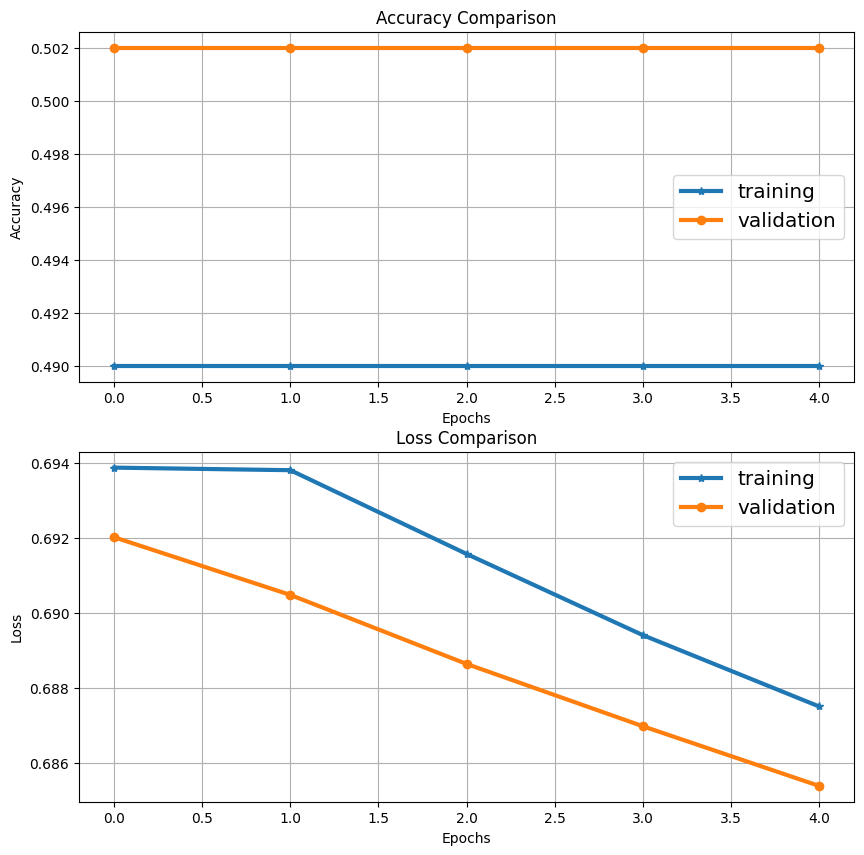

In [26]:
visualize_training(history)

### Retrieve the learned embeddings
Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape `(vocab_size, embedding-dimension)`. Here observe some things carefully.
* We are selecting only the first layer of the model because it is the embedding layer in our model descriptor. If you carefully look at the model description, you can get an idea of what I am talking about.

``` Python
#Model description
embedding_dim=300
model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
#   layers.Dense(16, activation='relu'),
  layers.Dense(1)
])
```

* When we run the summary() command for the model, we saw that `Embedding()` layer had **1044800   ** parameters. Which is exactly equal to **32,650x32 = 1044800.** Therefore it was basically telling the size of the embedding matrix that it was going to learn. However for the quick testing purpose, I would set `embedding_dim = 32 or 16`.

* In the summary of the model, we observe that `global_average_pooling1d` layer which is `GlobalAveragePooling1D()` has **0** parameters to learn because it was simply finding out the running average of the previous layers output.

* Similarly it is possible to explore the learned parameters of the last two layers. Feel free to explore them for better understanding.

In [ ]:
# Retrieving the layer
e = model.layers[0]
#Retrieving the weights learned in that layer.
weights = e.get_weights()[0]
# The weight matrix is basically a list type matrix. Let's convert them into a numpy array for easier visualization.
print(weights.shape)

We will now write the weights to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (containing the embedding), and a file of meta data (containing the words).

In [ ]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

## Visualize the embeddings
After you have run the previous segment of code, your output folder should have two files named
* vecs.tsv
* meta.tsv

To visualize our embeddings we will upload them to the embedding projector.

Open the [Embedding Projector](http://projector.tensorflow.org/) (this can also run in a local TensorBoard instance).

* Click on "Load data".

* Upload the two files we created above: `vecs.tsv` and `meta.tsv`.

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for **"beautiful"**. You may see neighbors like **"wonderful"**.

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

Note: experimentally, you may be able to produce more interpretable embeddings by using a simpler model. Try deleting the `Dense(16)` layer, retraining the model, and visualizing the embeddings again.

Let's find the location of the words man, woman, king, queen from the vocabulary and then retrieve their word embedding.

In [ ]:

def get_location(word, vocab):
    location = None
    for index, s in enumerate(vocab):
        if(s == word):
            location = index
            break
    return location
vocab = encoder.subwords

man = weights[get_location("man", vocab)]
woman = weights[get_location("woman", vocab)]
boy = weights[get_location("boy", vocab)]
girl = weights[get_location("girl", vocab)]

In [ ]:
what = boy - man + woman

Now for comparative analysis, lets calculate the similarity of what with each of them

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

print('Similarity between   man & what  : ', np.squeeze(cosine_similarity([what], [man])))
print('Similarity between   woman & what: ', np.squeeze(cosine_similarity([what], [woman])))
print('Similarity between   boy & what  : ', np.squeeze(cosine_similarity([what], [boy])))
print('Similarity between   girl & what : ', np.squeeze(cosine_similarity([what], [girl])))

Here we observe that, with the word **gird** our query has the highest similarity i.e. highest cosine value which eventually means the lowest angle between them in the vector space.